# Regularization

## 1. Introduction

### 1.1 Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize
from numpy.random import permutation
from sympy import var, diff, exp, latex, factor, log, simplify
from IPython.display import display, Math, Latex
np.set_printoptions(precision=4)
%matplotlib inline

### 1.2 Dataset

The in-sample and out-of-sample data is retrieved from the following sources:

```bash
curl -O http://work.caltech.edu/data/in.dta
curl -O http://work.caltech.edu/data/out.dta
```



## 2. Non-linear Transforms

### 2.1 Hypothesis Set

Consider the linear transform $z_i = \phi_i\left(\mathbf{x}\right)$ or $\mathbf{z} = \Phi\left(\mathbf{x}\right)$, with the following mapping:

$$\mathbf{x} = \left(x_0, x_1, \dots, x_d\right) \rightarrow \mathbf{z} = \left(z_0, z_1, \dots, z_{\tilde d}\right)$$

The final hypothesis, $\mathcal{X}$ space is:

$$g\left(\mathbf{x}\right) = \mathbf{\tilde w^T} \Phi\left(\mathbf{x}\right)$$

$$g\left(\mathbf{x}\right) = \left(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7\right) \left(\begin{array}{c}1\\x_1\\x_2\\x_1^2\\x_2^2\\x_1 x_2\\|x_1 - x_2|\\|x_1 + x_2|\end{array}\right) = w_0 + w_1 x_1 + w_2 x_2 + \dots$$

To implement the above hypothesis set on an arbitrary matrix $\mathbf{X}$,
we augment the matrix $\mathbf{X}$ with a *ones column*, and
non-linear features are added as new columns via the following two subroutines.

In [2]:
def add_ones_column(X):
    n = X.shape[0]
    x0 = np.ones((n,1))
    return np.hstack((x0,X))

In [3]:
def add_nonlinear_features(X,n):
    """
    Here 'n' can be 3 to 7, corresponding to one of the following ϕ_n:
    ϕ_0 = 1
    ϕ_1 = 1 + x_1
    ϕ_2 = 1 + x_1 + x_2
    ϕ_3 = 1 + x_1 + x_2 + x_1^2
    ϕ_4 = 1 + x_1 + x_2 + x_1^2 + x_2^2
    ϕ_5 = 1 + x_1 + x_2 + x_1^2 + x_2^2 + x_1 x_2
    ϕ_6 = 1 + x_1 + x_2 + x_1^2 + x_2^2 + x_1 x_2 + |x_1 - x_2|
    ϕ_7 = 1 + x_1 + x_2 + x_1^2 + x_2^2 + x_1 x_2 + |x_1 - x_2| + |x_1 + x_2|
    """
    m = X.shape[0]
    X = np.hstack((X,np.zeros((m,n-X.shape[1]+1))))
    if n >= 3: X[:,3] = X[:,1]**2
    if n >= 4: X[:,4] = X[:,2]**2
    if n >= 5: X[:,5] = X[:,1]*X[:,2]
    if n >= 6: X[:,6] = np.abs(X[:,1] - X[:,2])
    if n >= 7: X[:,7] = np.abs(X[:,1] + X[:,2])
    return(X)

### 2.2 Loading and Transforming the Data

The data is loaded and transformed as follows:

In [4]:
training = np.loadtxt("data/in.dta")
X_train = add_ones_column(training[:,:-1])
y_train = training[:,-1]
X_train = add_nonlinear_features(X_train,7)
n_train = y_train.shape[0]

testing  = np.loadtxt("data/out.dta")
X_test  = add_ones_column(testing[:,:-1])
y_test  = testing[:,-1]
X_test  = add_nonlinear_features(X_test,7)
n_test = y_test.shape[0]

n_features = X_train.shape[1]

### 2.2 Linear Regression (without regularization)

The [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) estimator for the weights is:

$$w = \left(\mathbf{X^T X}\right)^{-1}\mathbf{X^T y} = \mathbf{X^\dagger}y$$

where $\mathbf{X^\dagger} = \left(\mathbf{X^T X}\right)^{-1}\mathbf{X^T}$ is the [Moore–Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore–Penrose_pseudoinverse).

This is implemented via the following line of code in the subroutine below:

`w_linreg = np.dot(np.linalg.pinv(X),y)`

In [5]:
def train_without_regularization(X_train,y_train):
    w_no_reg = np.dot(np.linalg.pinv(X_train),y_train)
    return w_no_reg

def get_E_in_E_out(X_test,y_test,X_train,y_train,w,verbose=True):
    n_train = y_train.shape[0]
    n_test  = y_test.shape[0]
    y_train_eval = np.sign(np.dot(X_train,w)).astype(int)
    y_test_eval  = np.sign(np.dot(X_test,w)).astype(int)
    E_in = np.sum(y_train != y_train_eval) / n_train
    E_out = np.sum(y_test != y_test_eval) / n_test
    if verbose is True:
        print("E_in = {}".format(E_in))
        print("E_out = {}".format(E_out))
    return E_in,E_out

The un-regularized in-sample and out-of-sample error can be calculated as follows (in the next section, the regularized in-sample and out-of-sample errors will be calculated):

In [6]:
w_linreg = np.dot(np.linalg.pinv(X_train),y_train)
y_train_linreg = np.sign(np.dot(X_train,w_linreg))
y_test_linreg  = np.sign(np.dot(X_test,w_linreg))
E_in = np.sum(y_train != y_train_linreg) / n_train
E_out = np.sum(y_test != y_test_linreg) / n_test
print("E_in = {}".format(E_in))
print("E_out = {}".format(E_out))

E_in = 0.02857142857142857
E_out = 0.084


### 2.3 Linear Regression (with Regularization)

#### 2.3.1 Background

In order to perform regularization, a "soft-order" constraint is employed for the weights:

$$\sum\limits_{q=0}^Q w_q^2 \le C$$

Subject to the above constraint, our aim is to minimize the following cost function on the in-sample points:

$$E_{in}\left(\mathbf{w}\right) = \frac{1}{N} \sum\limits_{n=1}^N \left(\mathbf{w^T z_n - y_n}\right)^2 = \frac{1}{N}\left(\mathbf{Zw-y}\right)^T\left(\mathbf{Zw-y}\right)$$

The minimum of the above function occurs when:

$$\nabla E_{in}\left(\mathbf{w}\right) \propto -\mathbf{w_{reg}}$$
$$\nabla E_{in}\left(\mathbf{w}\right) = -2\frac{\lambda}{N}\mathbf{w_{reg}}$$

where in the last step, we have introduced $2\frac{\lambda}{N}$ as our constant of proportionality.

Hence, we wish to solve:

$$\nabla E_{in}\left(\mathbf{w_{reg}}\right) + 2\frac{\lambda}{N}\mathbf{w_{reg}} = 0$$

Notice that solving the above equation corresponds to minimizing the following:

$$E_{in}\left(\mathbf{w}\right) + \frac{\lambda}{N}\mathbf{w^T w}$$

This new cost function can be viewed as an augmented error, which we can write as follows:

$$E_{aug}\left(\mathbf{w}\right) = \frac{1}{N}\left(\mathbf{Zw-y}\right)^T \left(\mathbf{Zw-y}\right) + \frac{\lambda}{N}\mathbf{w^T w}$$

Minimizing the above cost function is equivalent to minimizing $E_{in}\left(\mathbf{w}\right)$ subject to the constraint $\mathbf{w^T w} \le C$

To determine the **regularized weights**, we minimize the augmented error as follows:

$$\nabla E_{aug}\left(\mathbf{w}\right) = 0$$

$$\mathbf{Z^T} \left(\mathbf{Zw-y}\right) + \lambda\mathbf{w} = 0$$

$$\left(\mathbf{Z^T Z} + \lambda\mathbf{I}\right)\mathbf{w} - \mathbf{Z^T y} = 0$$

$$\mathbf{w_{reg}} = \left(\mathbf{Z^T Z} + \lambda\mathbf{I}\right)^{-1}\mathbf{Z^T y}$$

In [7]:
def train_with_regularization(lmbda,X_train,y_train,use_sklearn=False):
    n_samples = y_train.shape[0]
    if use_sklearn is True:
        reg = linear_model.Ridge(alpha = lmbda/n_samples, fit_intercept=True)
        reg.fit(X_train,y_train)
        w_reg = reg.coef_
        w_reg[0] = reg.intercept_
    else:
        n_features=X_train.shape[1]
        ZTy = np.dot(X_train.T,y_train)
        ZTZ = np.dot(X_train.T,X_train)
        w_reg = np.dot(np.linalg.inv(ZTZ + lmbda*np.identity(n_features)),ZTy)
    return w_reg

In [8]:
def get_E_in_E_out(X_test,y_test,X_train,y_train,w):
    n_train = y_train.shape[0]
    n_test = y_test.shape[0]
    y_train_w = np.sign(np.dot(X_train,w))
    y_test_w  = np.sign(np.dot(X_test,w))
    E_in = np.sum(y_train != y_train_w) / n_train
    E_out = np.sum(y_test != y_test_w) / n_test
    return E_in, E_out

#### 2.3.2 Checking the above subroutine.

The data can be trained by either using the subroutine `train_without_regularization()` or setting $\lambda=0$ in the subroutine `train_with_regularization()`.  The weights obtained should be the same in either case, and this is easy to check with `numpy.allclose()`.

In [9]:
w_no_reg = train_without_regularization(X_train,y_train)
w_reg = train_with_regularization(0.0,X_train,y_train,use_sklearn=False)
assert np.allclose(w_no_reg,w_reg)
E_in,E_out = get_E_in_E_out(X_test,y_test,X_train,y_train,w_no_reg)

#### 2.3.3 Finding the best $\lambda$

To find the best choice of $\lambda$, the values of $E_{in}$ and $E_{out}$ are plotted over a range of values of $\lambda$.

In [10]:
def find_best_lambda(lmbd_arr,X_train,y_train,X_test,y_test,use_sklearn=False):
    E_in_arr = []
    E_out_arr = []
    w_arr = []
    for lmbda in lmbd_arr:
        w_reg = train_with_regularization(lmbda,X_train,y_train,use_sklearn=use_sklearn)
        E_in, E_out = get_E_in_E_out(X_test,y_test,X_train,y_train,w_reg)
        E_in_arr.append(E_in)
        E_out_arr.append(E_out)
        w_arr.append(w_reg)
    return np.array(E_in_arr), np.array(E_out_arr), np.array(w_arr)

In [11]:
def plot_regularization(fig,plot_id,title,lmbd_arr,E_in_reg,E_out_reg):
    ax = fig.add_subplot(plot_id)
    ax.semilogx(lmbd_arr,E_in_reg,'x-',label="$E_{in}$")
    ax.semilogx(lmbd_arr,E_out_reg,'o-',label="$E_{out}$")
    ax.set_xlabel('$\lambda$')
    ax.grid(True)
    ax.legend(loc='best',frameon=False)
    ax.set_title(title)

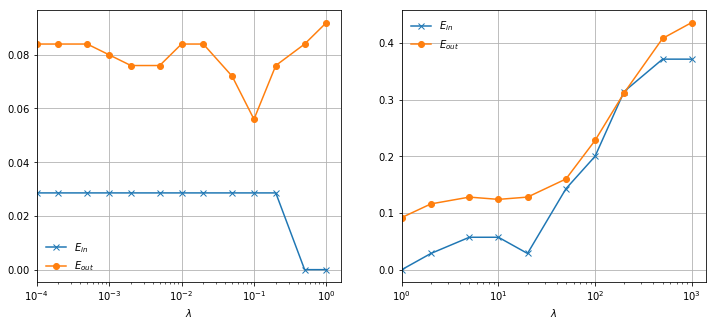

In [12]:
lmbd_arr1 = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
fig = plt.figure(figsize=(12,5))
E_in_reg1, E_out_reg1, w_reg1 = find_best_lambda(lmbd_arr1,X_train,y_train,X_test,y_test,False)
plot_regularization(fig,121,"",lmbd_arr1,E_in_reg1,E_out_reg1)
#E_in_sk, E_out_sk, w_sk = find_best_lambda(lmbd_arr,X_train,y_train,X_test,y_test,True)
#plot_regularization(fig,122,"sklearn",lmbd_arr,E_in_sk,E_out_sk)
lmbd_arr2 = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0]
E_in_reg2, E_out_reg2, w_reg2 = find_best_lambda(lmbd_arr2,X_train,y_train,X_test,y_test,False)
plot_regularization(fig,122,"",lmbd_arr2,E_in_reg2,E_out_reg2)

Here we can see that when regularization turned on ($\lambda \ne 0$):

* $\lambda = 10^{-3}$ has an $E_{in}$ of about 0.03, and an $E_{out}$ of 0.08.
* $\lambda = 10^{-1}$ has the best $E_{out}$ of about 0.06.
* $\lambda = 10^{3}$ has an $E_{in}$ and $E_{out}$ of about 0.4.

### 2.4 Validation Sets

The data may also be split into validation sets for training, and the new model evaluated on the final, held-out, test set.  In the following subroutine, the training set (`X_train_all,y_train_all`) is split one more time into a new training set (`X_train,y_train`) and a validation set (`X_valid,y_valid`).  By default, the first 25 points are designated as training points (`train_pts`).

In [13]:
def training_validation_test_split(training,testing,train_pts=25,k=7,swap=False):
    X_train_all = add_ones_column(training[:,:-1])
    y_train_all = training[:,-1]
    X_train_all = add_nonlinear_features(X_train_all,k)

    X_test  = add_ones_column(testing[:,:-1])
    y_test  = testing[:,-1]
    X_test  = add_nonlinear_features(X_test,k)

    val_pts = X_train_all.shape[0]-train_pts
    assert val_pts == y_train_all.shape[0]-train_pts
    if swap is True:
        X_train = X_train_all[val_pts:,:]
        X_valid = X_train_all[:val_pts,:]
        y_train = y_train_all[val_pts:]
        y_valid = y_train_all[:val_pts]
    else:
        X_train = X_train_all[:train_pts,:]
        X_valid = X_train_all[train_pts:,:]
        y_train = y_train_all[:train_pts]
        y_valid = y_train_all[train_pts:]

    assert X_train.shape[0]==train_pts
    assert X_valid.shape[0]==val_pts
    assert y_train.shape[0]==train_pts
    assert y_valid.shape[0]==val_pts
    n_features = X_train.shape[1]
    return X_train_all,y_train_all,X_train,y_train,X_valid,y_valid,X_test,y_test

In this example, the first 3,4,5,6, or 7 terms (corresponding to $\phi_3, \phi_4, \dots, \phi_7$) of the non-linear transform are used and the classification error of the validation set is evaluated.

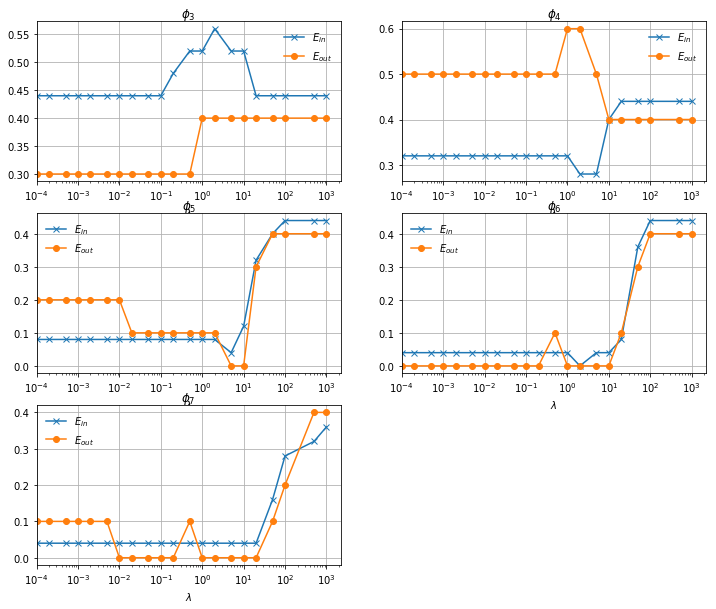

In [14]:
lmbd_arr = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05,
            0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0]
k_arr = np.array([3, 4, 5, 6, 7])
fig = plt.figure(figsize=(12,10))
plot_ids = [ 321, 322, 323, 324, 325 ]
for i,k in enumerate(k_arr):
    X_train_all,y_train_all,X_train,y_train,X_valid,y_valid,X_test,y_test = \
        training_validation_test_split(training,testing,k=k)
    E_in_reg, E_val_reg, w_reg_arr = find_best_lambda(lmbd_arr,X_train,y_train,X_valid,y_valid,False)
    plot_regularization(fig,plot_ids[i],"$\phi_{}$".format(k),lmbd_arr,E_in_reg,E_val_reg)

Here we can see that for small $\lambda$, $\phi_6$ has the lowest classification error on the validation set.

### 2.5 Plotting

The in-sample and out-of-sample error from the non-linear transforms can be visualized via contour plots.  In this case, we will use $\lambda = 0.1$ which had the lowest out-of-sample error.

In [15]:
def plot_data_nonlinear(fig,plot_id,X,y,w_arr,w_colors,titles):
    p = 2.0
    x1 = np.linspace(-p,p,100)
    x2 = np.linspace(-p,p,100)
    X1,X2 = np.meshgrid(x1,x2)
    X1_sq= X1**2
    X2_sq= X2**2
    X1X2 = X1*X2
    X1mX2= np.abs(X1-X2)
    X1pX2= np.abs(X1+X2)

    for i,w in enumerate(w_arr):
        G = w[0] + w[1]*X1 + w[2]*X2 + w[3]*X1_sq + w[4]*X2_sq + \
            w[5]*X1X2 + w[6]*X1mX2 + w[7]*X1pX2
        ax = fig.add_subplot(plot_id[i])
        ax.plot(X[y > 0,1],X[y > 0,2],'b+',label='Positive (+)')
        ax.plot(X[y < 0,1],X[y < 0,2],'r_',label='Negative (-)')
        cp0 = ax.contour(X1,X2,G,1,linewidth=4, levels=[0.0],
                         colors=w_colors[i])
        ax.clabel(cp0, inline=True, fontsize=14)
        #cp1 = ax.contour(X1,X2,Y,N=1,linewidth=4, levels=[-1.0, 1.0],
        #                 linestyles='dashed', colors=w_colors[i], alpha=0.3)
        cp1 = ax.contourf(X1,X2,G,1,linewidth=4, linestyles='dashed', alpha=0.8)
        ax.clabel(cp1, inline=True, fontsize=14)

        plt.colorbar(cp1)
        ax.set_title(titles[i])
        #ax.set_axis_off()  #ax.axis('off')
        #ax.axes.xaxis.set_ticks([])
        #ax.axes.yaxis.set_ticks([])
        ax.set_xlim(-p,p)
        ax.set_ylim(-p,p)
    fig.tight_layout()

In [16]:
w_no_reg = train_with_regularization(0.0,X_train_all,y_train_all,use_sklearn=False)
w_reg    = train_with_regularization(0.1,X_train_all,y_train_all,use_sklearn=False)
E_in_no_reg,E_out_no_reg = get_E_in_E_out(X_test,y_test,X_train_all,y_train_all,w_no_reg)
E_in_reg,   E_out_reg    = get_E_in_E_out(X_test,y_test,X_train_all,y_train_all,w_reg)

In [17]:
def string_Ein(E_in):
    return '$E_{in}=' + '{}'.format(np.round(E_in,5)) + '$'

def string_Eout(E_out):
    return '$E_{out}=' + '{}'.format(np.round(E_out,5)) + '$'

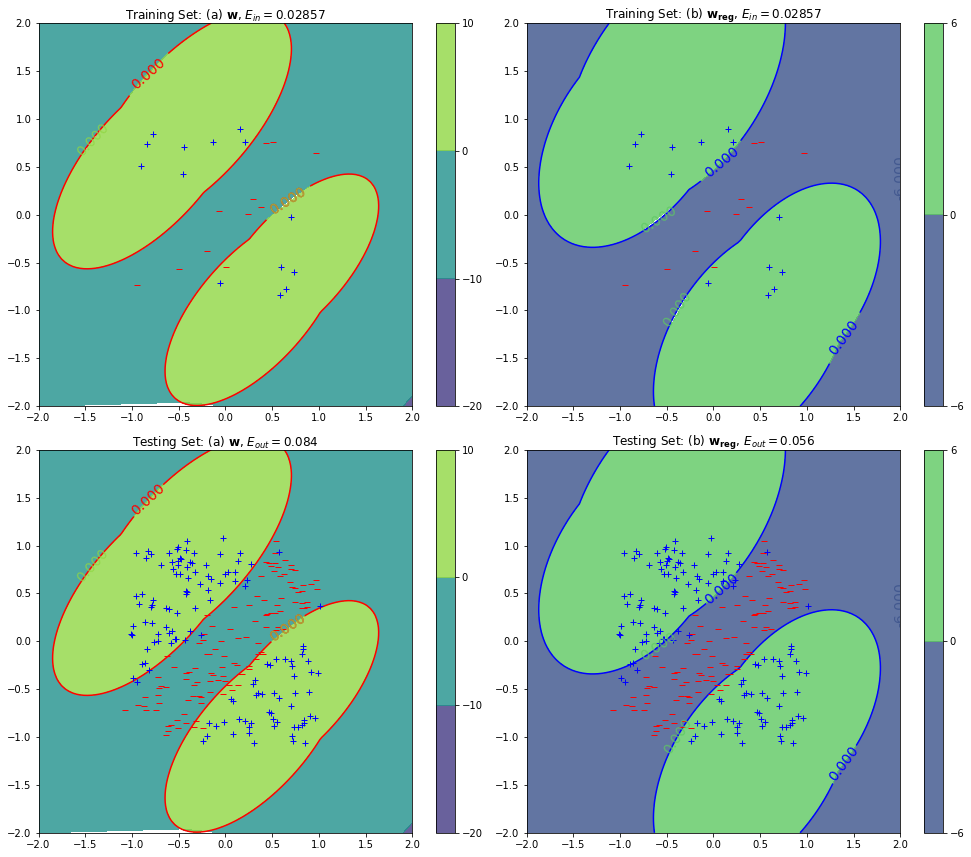

In [18]:
w_arr = [ w_no_reg, w_reg ]
w_colors = ['red', 'blue' ]
title_train = ['Training Set: (a) $\mathbf{w}$, ' + string_Ein(E_in_no_reg),
               'Training Set: (b) $\mathbf{w_{reg}}$, ' + string_Ein(E_in_reg)]
title_test  = ['Testing Set: (a) $\mathbf{w}$, ' + string_Eout(E_out_no_reg),
               'Testing Set: (b) $\mathbf{w_{reg}}$, ' + string_Eout(E_out_reg)]
fig = plt.figure(figsize=(14,12))
plot_data_nonlinear(fig,[ 221, 222 ],X_train,y_train,w_arr,w_colors,title_train)
plot_data_nonlinear(fig,[ 223, 224 ],X_test, y_test, w_arr,w_colors,title_test)

## 3. Hypothesis sets

Consider the following hypothesis set

$$\mathcal{H}_Q = \left\{ h \; | \; h(x) = \mathbf{w^T z} = \sum\limits_{q=0}^Q w_q L_q(x) \right\}$$

We thus have $\mathcal{H_4, H_3, H_2, H_1}$ as:

$$\mathcal{H}_4 = \left\{ h \; | \; h(x) = \mathbf{w^T z} = \sum\limits_{q=0}^4 w_q L_q(x) \right\}$$

$$\mathcal{H}_3 = \left\{ h \; | \; h(x) = \mathbf{w^T z} = \sum\limits_{q=0}^3 w_q L_q(x) \right\}$$

$$\mathcal{H}_2 = \left\{ h \; | \; h(x) = \mathbf{w^T z} = \sum\limits_{q=0}^2 w_q L_q(x) \right\}$$

$$\mathcal{H}_1 = \left\{ h \; | \; h(x) = \mathbf{w^T z} = \sum\limits_{q=0}^1 w_q L_q(x) \right\}$$

We also have:

$$\mathcal{H}\left(Q, C, Q_0\right) = \left\{ h \; | \; h(x) = \mathbf{w^T z} \in \mathcal{H}_Q; w_Q = C \text{ for } q \ge Q_0 \right\}$$

For $Q = 10, C = 0, Q_0 = 3$:
$$\mathcal{H}\left(10, C, 3\right) = \left\{ h \; | \; h(x) = \mathbf{w^T z} \in \mathcal{H}_{10}; w_Q = 0 \text{ for } q \ge 3 \right\} = \mathcal{H}_2$$

For $Q = 10, C = 0, Q_0 = 4$:
$$\mathcal{H}\left(10, C, 4\right) = \left\{ h \; | \; h(x) = \mathbf{w^T z} \in \mathcal{H}_{10}; w_Q = 0 \text{ for } q \ge 4 \right\} = \mathcal{H}_3$$

Hence we have:

$$\mathcal{H}\left(10, C, 3\right) \cap \mathcal{H}\left(10, C, 4\right) = \mathcal{H}_2 \cap \mathcal{H}_3 = \mathcal{H}_2$$

## 4. Neural Networks

### Forward Propagation

$$x_j^{(l)} = \theta \left( s_j^{(l)} \right) = \theta \left( \sum\limits_{i=0}^{d^{(l-1)}} w_{ij}^{(l)} x_i^{(l-1)} \right)$$

where

$$\theta\left(s\right) = \tanh\left(s\right)$$

### Backpropagation

$$\delta w_{ij}^{(l)} = -\eta x_i^{(l-1)} \delta_j^{(l)}$$

where

$$\delta_j^{(l-1)} = \left[1 - \left(x_i^{(l-1)}\right)^2\right] \sum_{j=1}^{d^{(l)}} w_{ij}^{(l)} \delta_j^{(l)}$$

### Gradient Descent

$$\mathbf{w}\left(t+1\right) = \mathbf{w}\left(t\right) - \eta \nabla E_{in}\left(\mathbf{w}\left(t\right)\right) - 2\eta \frac{\lambda}{N} \mathbf{w}\left(t\right)$$

$$\mathbf{w}\left(t+1\right) = \mathbf{w}\left(t\right)\left(1 - 2\eta \frac{\lambda}{N}\right) - \eta \nabla E_{in}\left(\mathbf{w}\left(t\right)\right)$$

where

$$\mathbf{w^T w} = \sum\limits_{l=1}^L \sum\limits_{i=0}^{d^{(l-1)}} \sum\limits_{j=1}^{d^{(l)}} \left( w_{ij}^{(l)}\right)^2$$


Consider a neural network with 5 inputs, 3 nodes at the hidden layer, and a single node in the output layer, i.e. $d^{(0)} = 5, d^{(1)} = 3, d^{(2)} = 1$:

Further reading: http://home.agh.edu.pl/~vlsi/AI/backp_t_en/backprop.html

In [19]:
def calculate_weights(layer_nodes):
    """
    Calculate the number of weights required for a neural network,
    where layer_nodes contains the number of nodes for each layer,
    excluding bias units.
    """
    n = len(layer_nodes)
    total = 0
    for i in range(n-1):
        prev = layer_nodes[i]+1  # Add 1 to include bias unit
        curr = layer_nodes[i+1]
        total += prev*curr
        print("Layer {}: d+1={} -> {} = {}".format(i+1,prev,curr,prev*curr))
    return total

For a neural network with 5 inputs, 3 nodes in the hidden layer, and 1 node in the output layer, the total number of weights is calculated as follows:

In [20]:
calculate_weights(layer_nodes = [5, 3, 1])

Layer 1: d+1=6 -> 3 = 18
Layer 2: d+1=4 -> 1 = 4


22

Suppose we wish to calculate the minimum and maximum number of weights of a neural network with the restriction that it has 10 input units, 36 hidden units, and one output unit.  The minimum number of weights occurs when the 36 hidden units is split into 18 hidden layers (each with 1 bias node + 1 regular node).  The number of weights is calculated as follows:

In [21]:
calculate_weights(layer_nodes = [9] + ([1] * 18) + [1])

Layer 1: d+1=10 -> 1 = 10
Layer 2: d+1=2 -> 1 = 2
Layer 3: d+1=2 -> 1 = 2
Layer 4: d+1=2 -> 1 = 2
Layer 5: d+1=2 -> 1 = 2
Layer 6: d+1=2 -> 1 = 2
Layer 7: d+1=2 -> 1 = 2
Layer 8: d+1=2 -> 1 = 2
Layer 9: d+1=2 -> 1 = 2
Layer 10: d+1=2 -> 1 = 2
Layer 11: d+1=2 -> 1 = 2
Layer 12: d+1=2 -> 1 = 2
Layer 13: d+1=2 -> 1 = 2
Layer 14: d+1=2 -> 1 = 2
Layer 15: d+1=2 -> 1 = 2
Layer 16: d+1=2 -> 1 = 2
Layer 17: d+1=2 -> 1 = 2
Layer 18: d+1=2 -> 1 = 2
Layer 19: d+1=2 -> 1 = 2


46

To calculate the maximum number of weights, a neural network with a single hidden layer would have the following number of weights:

In [22]:
calculate_weights(layer_nodes = [9, 35, 1])

Layer 1: d+1=10 -> 35 = 350
Layer 2: d+1=36 -> 1 = 36


386

If we had two hidden layers:

In [23]:
calculate_weights([9, 17, 17, 1])

Layer 1: d+1=10 -> 17 = 170
Layer 2: d+1=18 -> 17 = 306
Layer 3: d+1=18 -> 1 = 18


494

In [24]:
calculate_weights([9, 18, 16, 1])

Layer 1: d+1=10 -> 18 = 180
Layer 2: d+1=19 -> 16 = 304
Layer 3: d+1=17 -> 1 = 17


501

In [25]:
calculate_weights([9, 19, 15, 1])

Layer 1: d+1=10 -> 19 = 190
Layer 2: d+1=20 -> 15 = 300
Layer 3: d+1=16 -> 1 = 16


506

In [26]:
calculate_weights([9, 20, 14, 1])

Layer 1: d+1=10 -> 20 = 200
Layer 2: d+1=21 -> 14 = 294
Layer 3: d+1=15 -> 1 = 15


509

In [27]:
calculate_weights([9, 21, 13, 1])

Layer 1: d+1=10 -> 21 = 210
Layer 2: d+1=22 -> 13 = 286
Layer 3: d+1=14 -> 1 = 14


510

If we had 3 hidden layers:

In [28]:
calculate_weights([9, 11, 11, 11, 1])

Layer 1: d+1=10 -> 11 = 110
Layer 2: d+1=12 -> 11 = 132
Layer 3: d+1=12 -> 11 = 132
Layer 4: d+1=12 -> 1 = 12


386

If we had 4 hidden layers:

In [29]:
calculate_weights([9, 8, 8, 8, 8, 1])

Layer 1: d+1=10 -> 8 = 80
Layer 2: d+1=9 -> 8 = 72
Layer 3: d+1=9 -> 8 = 72
Layer 4: d+1=9 -> 8 = 72
Layer 5: d+1=9 -> 1 = 9


305

Hence, the maximum number of weights corresponds to the neural network [9, 21, 13, 1], with 10 units in the input layer, 22 units in the first hidden layer, and 14 units in the second hidden layer, and 1 unit in the final output layer.  The total number of weights for this network is 510.